In [1]:
import utils
from get_dataset import get_dataset
import random
import time
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torchtext.data import Iterator
from importlib import reload
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# If you have dark theme
from matplotlib.pyplot import rcParams
rcParams['figure.facecolor'] = 'white'

In [3]:
# Setup logger
import logging
logging.basicConfig(filename='log.txt',
                    level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [7]:
dataset, emb_weights = get_dataset()
dataset.fields['review'].include_lengths = True

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

<br>

In [8]:
class GRUmodel(nn.Module):
    def __init__(self, vocab_size, embed_dim, embed_vecs=None, hidden_size=16,
                num_layers=1, dropout=0, bidirectional=False):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if embed_vecs is not None:
            self.embedding = nn.Embedding.from_pretrained(embed_vecs)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout,
                          bidirectional=bidirectional, batch_first=True)
        self.head = nn.Linear(self.num_directions*self.hidden_size, 2)

        
    def forward(self, batch):
        batch, lengths = batch
        batch_dim, _ = batch.shape
        
        embedded = self.embedding(batch)
        embedded_packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        outputs_packed, hiddens = self.gru(embedded_packed)
        
        last_hidden = hiddens.view(self.num_layers, self.num_directions, batch_dim, self.hidden_size)[-1]
        hidden_concat = last_hidden.transpose(1,0).reshape(batch_dim, self.num_directions*self.hidden_size)
        
        logging.debug('batch shape : {}'.format(batch.shape))
        logging.debug('embedding shape : {}'.format(embedded.shape))
        logging.debug('hiddens shape : {}'.format(hiddens.shape))
        logging.debug('hidden_concat shape : {}'.format(hidden_concat.shape))
        
        return self.head(hidden_concat)

In [9]:
def learner(model, loss_fn, optimiser, epochs=1, bs=4, device=device, grad_clip=None):
    start_time = time.time()
    for epoch in range(epochs):
        
        total_loss = 0
        for i, batch in enumerate(Iterator(ds_train, bs, shuffle=True, device=device, ), 1):
            optimiser.zero_grad()
            
            output = model(batch.review)
            loss = loss_fn(output, batch.label)
            total_loss += loss.item()
        
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimiser.step()

            if not i % (len(ds_train)//(bs*3)):
                avg_loss = total_loss / (len(ds_train)//(bs*3))
                val_loss, val_accuracy = utils.validate(ds_val, loss_fn, model)
                print('Epoch : {}, batch : {}, train_loss = {:.4f}, val_loss = {:.4f}, val_accuracy : {:.3f}, time = {:.0f}s'.format(
                        epoch + 1, i, avg_loss, val_loss, val_accuracy, time.time() - start_time))
                total_loss = 0

In [18]:
vocab_size = len(emb_weights)
embed_size = 300

model = GRUmodel(vocab_size, embed_size, emb_weights.clone(), num_layers=2, hidden_size=32, bidirectional=True).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

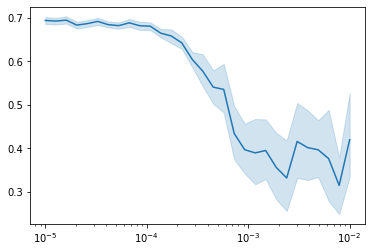

In [19]:
optimiser = Adam(model.parameters())
utils.lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-5, 1e-2], bs=8, avg_over_batches=30)

In [20]:
optimiser = Adam(model.parameters(), lr=4e-4)
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.6628, val_loss = 0.6419, val_accuracy : 0.577, time = 8s
Epoch : 1, batch : 200, train_loss = 0.5245, val_loss = 0.4940, val_accuracy : 0.770, time = 18s
Epoch : 1, batch : 300, train_loss = 0.4617, val_loss = 0.4294, val_accuracy : 0.787, time = 27s
Epoch : 2, batch : 100, train_loss = 0.3951, val_loss = 0.4105, val_accuracy : 0.810, time = 37s
Epoch : 2, batch : 200, train_loss = 0.3239, val_loss = 0.3898, val_accuracy : 0.827, time = 46s
Epoch : 2, batch : 300, train_loss = 0.3645, val_loss = 0.3771, val_accuracy : 0.823, time = 56s
Epoch : 3, batch : 100, train_loss = 0.3267, val_loss = 0.3729, val_accuracy : 0.847, time = 65s
Epoch : 3, batch : 200, train_loss = 0.2632, val_loss = 0.3721, val_accuracy : 0.837, time = 75s
Epoch : 3, batch : 300, train_loss = 0.3136, val_loss = 0.3612, val_accuracy : 0.843, time = 85s
Epoch : 4, batch : 100, train_loss = 0.2793, val_loss = 0.3609, val_accuracy : 0.860, time = 95s
Epoch : 4, batch : 200, train_l

In [21]:
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, epochs=3, bs=8)

Epoch : 1, batch : 100, train_loss = 0.1950, val_loss = 0.3705, val_accuracy : 0.863, time = 9s
Epoch : 1, batch : 200, train_loss = 0.1320, val_loss = 0.3690, val_accuracy : 0.857, time = 19s
Epoch : 1, batch : 300, train_loss = 0.1660, val_loss = 0.3751, val_accuracy : 0.870, time = 27s
Epoch : 2, batch : 100, train_loss = 0.1662, val_loss = 0.3762, val_accuracy : 0.873, time = 36s
Epoch : 2, batch : 200, train_loss = 0.1177, val_loss = 0.3801, val_accuracy : 0.853, time = 45s
Epoch : 2, batch : 300, train_loss = 0.1521, val_loss = 0.3868, val_accuracy : 0.877, time = 54s
Epoch : 3, batch : 100, train_loss = 0.1499, val_loss = 0.3863, val_accuracy : 0.873, time = 64s
Epoch : 3, batch : 200, train_loss = 0.1073, val_loss = 0.3926, val_accuracy : 0.860, time = 73s
Epoch : 3, batch : 300, train_loss = 0.1386, val_loss = 0.4009, val_accuracy : 0.877, time = 82s


<br>

### introduce dropout

In [31]:
class GRUmodel(nn.Module):
    def __init__(self, vocab_size, embed_dim, embed_vecs=None, hidden_size=16,
                num_layers=1, dropout=(0,0), bidirectional=False):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if embed_vecs is not None:
            self.embedding = nn.Embedding.from_pretrained(embed_vecs)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=dropout[0])
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout[1],
                          bidirectional=bidirectional, batch_first=True)
        self.head = nn.Linear(self.num_directions*self.hidden_size, 2)

        
    def forward(self, batch):
        batch, lengths = batch
        batch_dim, _ = batch.shape
        
        embedded = self.dropout(self.embedding(batch))
        embedded_packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        outputs_packed, hiddens = self.gru(embedded_packed)
        
        last_hidden = hiddens.view(self.num_layers, self.num_directions, batch_dim, self.hidden_size)[-1]
        hidden_concat = last_hidden.transpose(1,0).reshape(batch_dim, self.num_directions*self.hidden_size)
        
        logging.debug('batch shape : {}'.format(batch.shape))
        logging.debug('embedding shape : {}'.format(embedded.shape))
        logging.debug('hiddens shape : {}'.format(hiddens.shape))
        logging.debug('hidden_concat shape : {}'.format(hidden_concat.shape))
        
        return self.head(hidden_concat)

In [23]:
vocab_size = len(emb_weights)
embed_size = 300

model = GRUmodel(vocab_size, embed_size, emb_weights.clone(), num_layers=2, hidden_size=32, bidirectional=True, dropout=(0.3, 0.3)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

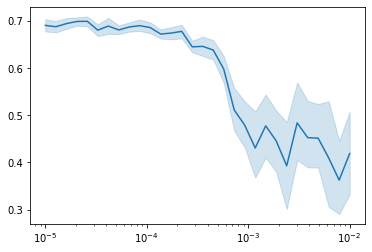

In [24]:
optimiser = Adam(model.parameters())
utils.lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-5, 1e-2], bs=8, avg_over_batches=30)

In [25]:
optimiser = Adam(model.parameters(), lr=5e-4)
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.6763, val_loss = 0.6489, val_accuracy : 0.587, time = 8s
Epoch : 1, batch : 200, train_loss = 0.5883, val_loss = 0.5592, val_accuracy : 0.740, time = 16s
Epoch : 1, batch : 300, train_loss = 0.5137, val_loss = 0.4586, val_accuracy : 0.793, time = 26s
Epoch : 2, batch : 100, train_loss = 0.4430, val_loss = 0.4517, val_accuracy : 0.777, time = 36s
Epoch : 2, batch : 200, train_loss = 0.3949, val_loss = 0.4151, val_accuracy : 0.823, time = 45s
Epoch : 2, batch : 300, train_loss = 0.4136, val_loss = 0.3894, val_accuracy : 0.843, time = 53s
Epoch : 3, batch : 100, train_loss = 0.3889, val_loss = 0.3939, val_accuracy : 0.833, time = 63s
Epoch : 3, batch : 200, train_loss = 0.3186, val_loss = 0.3872, val_accuracy : 0.847, time = 73s
Epoch : 3, batch : 300, train_loss = 0.3676, val_loss = 0.3785, val_accuracy : 0.843, time = 83s
Epoch : 4, batch : 100, train_loss = 0.3373, val_loss = 0.3817, val_accuracy : 0.853, time = 95s
Epoch : 4, batch : 200, train_l

In [26]:
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, epochs=3, bs=8)

Epoch : 1, batch : 100, train_loss = 0.2970, val_loss = 0.3490, val_accuracy : 0.873, time = 7s
Epoch : 1, batch : 200, train_loss = 0.2388, val_loss = 0.3372, val_accuracy : 0.860, time = 14s
Epoch : 1, batch : 300, train_loss = 0.2889, val_loss = 0.3384, val_accuracy : 0.860, time = 22s
Epoch : 2, batch : 100, train_loss = 0.2572, val_loss = 0.3639, val_accuracy : 0.877, time = 30s
Epoch : 2, batch : 200, train_loss = 0.2210, val_loss = 0.3435, val_accuracy : 0.860, time = 37s
Epoch : 2, batch : 300, train_loss = 0.2824, val_loss = 0.3516, val_accuracy : 0.867, time = 45s
Epoch : 3, batch : 100, train_loss = 0.2462, val_loss = 0.3610, val_accuracy : 0.870, time = 53s
Epoch : 3, batch : 200, train_loss = 0.2220, val_loss = 0.3488, val_accuracy : 0.860, time = 60s
Epoch : 3, batch : 300, train_loss = 0.2541, val_loss = 0.3473, val_accuracy : 0.860, time = 68s


In [27]:
model.embedding.weight.requires_grad_(True);
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, epochs=3, bs=8)

Epoch : 1, batch : 100, train_loss = 0.2954, val_loss = 0.3514, val_accuracy : 0.870, time = 8s
Epoch : 1, batch : 200, train_loss = 0.2138, val_loss = 0.3347, val_accuracy : 0.867, time = 18s
Epoch : 1, batch : 300, train_loss = 0.2600, val_loss = 0.3300, val_accuracy : 0.873, time = 30s
Epoch : 2, batch : 100, train_loss = 0.2460, val_loss = 0.3375, val_accuracy : 0.870, time = 40s
Epoch : 2, batch : 200, train_loss = 0.2149, val_loss = 0.3292, val_accuracy : 0.870, time = 51s
Epoch : 2, batch : 300, train_loss = 0.2358, val_loss = 0.3326, val_accuracy : 0.873, time = 62s
Epoch : 3, batch : 100, train_loss = 0.2501, val_loss = 0.3342, val_accuracy : 0.880, time = 74s
Epoch : 3, batch : 200, train_loss = 0.1870, val_loss = 0.3228, val_accuracy : 0.877, time = 83s
Epoch : 3, batch : 300, train_loss = 0.2169, val_loss = 0.3271, val_accuracy : 0.873, time = 92s


<br>

### Add concat pooling layer

In [39]:
class GRUmodel(nn.Module):
    def __init__(self, vocab_size, embed_dim, embed_vecs=None, hidden_size=512,
                num_layers=1, dropout=(0, 0), bidirectional=False):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if embed_vecs is not None:
            self.embedding = nn.Embedding.from_pretrained(embed_vecs)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout[1],
                          bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(p=dropout[0])
        self.head = nn.Linear(3*self.num_directions*self.hidden_size, 2)

        
    def forward(self, batch):
        batch, lengths = batch
        batch_dim, _ = batch.shape
        
        embedded = self.dropout(self.embedding(batch))
        embedded_packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        outputs_packed, hiddens = self.gru(embedded_packed)
        outputs, lengths = nn.utils.rnn.pad_packed_sequence(outputs_packed, batch_first=True)
        
        last_hidden = hiddens.view(self.num_layers, self.num_directions, batch_dim, self.hidden_size)[-1,:,:,:]
        hidden_concat = last_hidden.transpose(1,0).reshape(batch_dim, self.num_directions*self.hidden_size)
        
        avg_pool = torch.sum(outputs, dim=1)/lengths.unsqueeze(1)
        max_pool = torch.cat([sample[:length].max(dim=0)[0].unsqueeze(0) for sample, length in zip(outputs, lengths)], dim=0)
        
        logging.debug('batch shape : {}'.format(batch.shape))
        logging.debug('embedding shape : {}'.format(embedded.shape))
        logging.debug('hiddens shape : {}'.format(hiddens.shape))
        logging.debug('outputs shape : {}'.format(outputs.shape))
        logging.debug('avg_pool shape : {}'.format(avg_pool.shape))
        logging.debug('max_pool shape : {}'.format(max_pool.shape))
        logging.debug('hidden_concat shape : {}'.format(hidden_concat.shape))
        
        return self.head(torch.cat([hidden_concat, avg_pool, max_pool], dim=1))

In [49]:
vocab_size = len(emb_weights)
embed_size = 300

model = GRUmodel(vocab_size, embed_size, emb_weights.clone(), num_layers=2, hidden_size=32, bidirectional=True, dropout=(0.3, 0.3)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

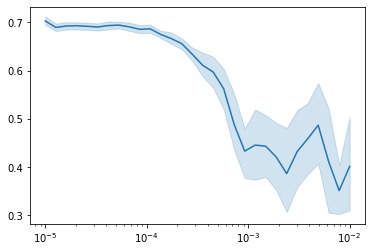

In [43]:
optimiser = Adam(model.parameters())
utils.lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-5, 1e-2], bs=8, avg_over_batches=30)

In [50]:
optimiser = Adam(model.parameters(), lr=3e-4)
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.6843, val_loss = 0.6720, val_accuracy : 0.533, time = 8s
Epoch : 1, batch : 200, train_loss = 0.6455, val_loss = 0.6033, val_accuracy : 0.713, time = 20s
Epoch : 1, batch : 300, train_loss = 0.5738, val_loss = 0.5507, val_accuracy : 0.710, time = 29s
Epoch : 2, batch : 100, train_loss = 0.5124, val_loss = 0.4799, val_accuracy : 0.753, time = 41s
Epoch : 2, batch : 200, train_loss = 0.4293, val_loss = 0.4500, val_accuracy : 0.793, time = 51s
Epoch : 2, batch : 300, train_loss = 0.4460, val_loss = 0.4140, val_accuracy : 0.800, time = 61s
Epoch : 3, batch : 100, train_loss = 0.4158, val_loss = 0.4171, val_accuracy : 0.813, time = 72s
Epoch : 3, batch : 200, train_loss = 0.3775, val_loss = 0.3942, val_accuracy : 0.820, time = 80s
Epoch : 3, batch : 300, train_loss = 0.4071, val_loss = 0.3802, val_accuracy : 0.830, time = 89s
Epoch : 4, batch : 100, train_loss = 0.3745, val_loss = 0.3818, val_accuracy : 0.837, time = 99s
Epoch : 4, batch : 200, train_l

In [51]:
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.3266, val_loss = 0.3538, val_accuracy : 0.863, time = 8s
Epoch : 1, batch : 200, train_loss = 0.3044, val_loss = 0.3431, val_accuracy : 0.850, time = 17s
Epoch : 1, batch : 300, train_loss = 0.3444, val_loss = 0.3415, val_accuracy : 0.853, time = 26s
Epoch : 2, batch : 100, train_loss = 0.3294, val_loss = 0.3515, val_accuracy : 0.860, time = 37s
Epoch : 2, batch : 200, train_loss = 0.2937, val_loss = 0.3380, val_accuracy : 0.850, time = 48s
Epoch : 2, batch : 300, train_loss = 0.3246, val_loss = 0.3397, val_accuracy : 0.853, time = 57s
Epoch : 3, batch : 100, train_loss = 0.3206, val_loss = 0.3584, val_accuracy : 0.857, time = 66s
Epoch : 3, batch : 200, train_loss = 0.3016, val_loss = 0.3383, val_accuracy : 0.847, time = 74s
Epoch : 3, batch : 300, train_loss = 0.3246, val_loss = 0.3364, val_accuracy : 0.863, time = 83s
Epoch : 4, batch : 100, train_loss = 0.3174, val_loss = 0.3479, val_accuracy : 0.867, time = 92s
Epoch : 4, batch : 200, train_l

In [53]:
model.embedding.weight.requires_grad_(True);
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.2802, val_loss = 0.3334, val_accuracy : 0.873, time = 13s
Epoch : 1, batch : 200, train_loss = 0.2577, val_loss = 0.3178, val_accuracy : 0.883, time = 24s
Epoch : 1, batch : 300, train_loss = 0.2795, val_loss = 0.3122, val_accuracy : 0.877, time = 35s
Epoch : 2, batch : 100, train_loss = 0.2416, val_loss = 0.3227, val_accuracy : 0.877, time = 48s
Epoch : 2, batch : 200, train_loss = 0.2224, val_loss = 0.3156, val_accuracy : 0.883, time = 61s
Epoch : 2, batch : 300, train_loss = 0.2752, val_loss = 0.3095, val_accuracy : 0.880, time = 76s
Epoch : 3, batch : 100, train_loss = 0.2228, val_loss = 0.3304, val_accuracy : 0.870, time = 89s
Epoch : 3, batch : 200, train_loss = 0.2389, val_loss = 0.3103, val_accuracy : 0.893, time = 103s
Epoch : 3, batch : 300, train_loss = 0.2578, val_loss = 0.3018, val_accuracy : 0.873, time = 116s
Epoch : 4, batch : 100, train_loss = 0.2329, val_loss = 0.3105, val_accuracy : 0.880, time = 134s
Epoch : 4, batch : 200, tra

<br>

### GRU with dot product attention on the outputs

In [61]:
class Attention(nn.Module):
    def __init__(self, query_dim):
        super(Attention, self).__init__()
        self.scale = 1. / math.sqrt(query_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, query, keys, values):
        # Query = [BxQ]
        # Keys = [BxTxQ]
        # Values = [BxTxQ]
        # Outputs = a:[TxB], lin_comb:[BxQ]

        query = query.unsqueeze(1) # [BxQ] -> [Bx1xQ]
        keys = keys.transpose(1,2) # [BxTxQ] -> [BxQxT]
        energy = torch.bmm(query, keys) # [Bx1xQ]x[BxQxT] -> [Bx1xT]
        energy = self.softmax(energy.mul_(self.scale)) # scale, normalize

        linear_combination = torch.bmm(energy, values).squeeze(1) #[Bx1xT]x[BxTxQ] -> [BxQ]
        return energy, linear_combination

In [62]:
class GRU_Attention_model(nn.Module):
    def __init__(self, vocab_size, embed_dim, embed_vecs=None, hidden_size=512,
                num_layers=1, dropout=(0, 0), bidirectional=False):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if embed_vecs is not None:
            self.embedding = nn.Embedding.from_pretrained(embed_vecs)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout[1],
                          bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(p=dropout[0])
        self.attention = Attention(self.hidden_size*self.num_directions)
        self.head = nn.Linear(self.num_directions*self.hidden_size, 2)

        
    def forward(self, batch):
        batch, lengths = batch
        batch_dim, _ = batch.shape
        
        embedded = self.dropout(self.embedding(batch))
        embedded_packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        outputs_packed, hiddens = self.gru(embedded_packed)
        outputs, lengths = nn.utils.rnn.pad_packed_sequence(outputs_packed, batch_first=True)
        
        last_hidden = hiddens.view(self.num_layers, self.num_directions, batch_dim, self.hidden_size)[-1,:,:,:]
        hidden_concat = last_hidden.transpose(1,0).reshape(batch_dim, self.num_directions*self.hidden_size)
        
        energy, attended_output = self.attention(hidden_concat, outputs, outputs)
        
        logging.debug('batch shape : {}'.format(batch.shape))
        logging.debug('embedding shape : {}'.format(embedded.shape))
        logging.debug('hiddens shape : {}'.format(hiddens.shape))
        logging.debug('outputs shape : {}'.format(outputs.shape))
        logging.debug('hidden_concat shape : {}'.format(hidden_concat.shape))
        logging.debug('attended_output shape : {}'.format(attended_output.shape))
        
        return self.head(attended_output)

In [65]:
vocab_size = len(emb_weights)
embed_size = 300

model = GRU_Attention_model(vocab_size, embed_size, emb_weights.clone(), num_layers=2, hidden_size=32, bidirectional=True, dropout=(0.3, 0.3)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

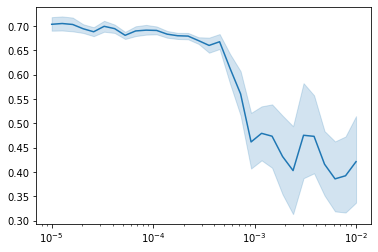

In [66]:
optimiser = Adam(model.parameters())
utils.lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-5, 1e-2], bs=8, avg_over_batches=30)

In [67]:
optimiser = Adam(model.parameters(), lr=5e-4)
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.6827, val_loss = 0.6754, val_accuracy : 0.500, time = 8s
Epoch : 1, batch : 200, train_loss = 0.6038, val_loss = 0.5632, val_accuracy : 0.750, time = 18s
Epoch : 1, batch : 300, train_loss = 0.5265, val_loss = 0.4710, val_accuracy : 0.780, time = 29s
Epoch : 2, batch : 100, train_loss = 0.4749, val_loss = 0.4463, val_accuracy : 0.790, time = 39s
Epoch : 2, batch : 200, train_loss = 0.3999, val_loss = 0.4195, val_accuracy : 0.840, time = 49s
Epoch : 2, batch : 300, train_loss = 0.4301, val_loss = 0.3809, val_accuracy : 0.837, time = 58s
Epoch : 3, batch : 100, train_loss = 0.3940, val_loss = 0.3970, val_accuracy : 0.830, time = 68s
Epoch : 3, batch : 200, train_loss = 0.3274, val_loss = 0.3924, val_accuracy : 0.840, time = 77s
Epoch : 3, batch : 300, train_loss = 0.3674, val_loss = 0.3605, val_accuracy : 0.853, time = 86s
Epoch : 4, batch : 100, train_loss = 0.3629, val_loss = 0.3692, val_accuracy : 0.853, time = 96s
Epoch : 4, batch : 200, train_l

In [68]:
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, epochs=3, bs=8)

Epoch : 1, batch : 100, train_loss = 0.2785, val_loss = 0.3561, val_accuracy : 0.877, time = 7s
Epoch : 1, batch : 200, train_loss = 0.2561, val_loss = 0.3295, val_accuracy : 0.857, time = 16s
Epoch : 1, batch : 300, train_loss = 0.2835, val_loss = 0.3289, val_accuracy : 0.853, time = 24s
Epoch : 2, batch : 100, train_loss = 0.2835, val_loss = 0.3380, val_accuracy : 0.870, time = 34s
Epoch : 2, batch : 200, train_loss = 0.2445, val_loss = 0.3308, val_accuracy : 0.857, time = 44s
Epoch : 2, batch : 300, train_loss = 0.2797, val_loss = 0.3319, val_accuracy : 0.867, time = 52s
Epoch : 3, batch : 100, train_loss = 0.2684, val_loss = 0.3547, val_accuracy : 0.883, time = 62s
Epoch : 3, batch : 200, train_loss = 0.2271, val_loss = 0.3307, val_accuracy : 0.857, time = 72s
Epoch : 3, batch : 300, train_loss = 0.2741, val_loss = 0.3276, val_accuracy : 0.860, time = 83s


In [69]:
model.embedding.weight.requires_grad_(True);
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.2708, val_loss = 0.3394, val_accuracy : 0.883, time = 9s
Epoch : 1, batch : 200, train_loss = 0.2286, val_loss = 0.3246, val_accuracy : 0.850, time = 20s
Epoch : 1, batch : 300, train_loss = 0.2753, val_loss = 0.3209, val_accuracy : 0.863, time = 31s
Epoch : 2, batch : 100, train_loss = 0.2428, val_loss = 0.3248, val_accuracy : 0.887, time = 42s
Epoch : 2, batch : 200, train_loss = 0.2107, val_loss = 0.3220, val_accuracy : 0.870, time = 53s
Epoch : 2, batch : 300, train_loss = 0.2628, val_loss = 0.3215, val_accuracy : 0.880, time = 64s
Epoch : 3, batch : 100, train_loss = 0.2422, val_loss = 0.3408, val_accuracy : 0.883, time = 76s
Epoch : 3, batch : 200, train_loss = 0.1983, val_loss = 0.3157, val_accuracy : 0.873, time = 89s
Epoch : 3, batch : 300, train_loss = 0.2385, val_loss = 0.3176, val_accuracy : 0.877, time = 101s
Epoch : 4, batch : 100, train_loss = 0.2171, val_loss = 0.3218, val_accuracy : 0.890, time = 113s
Epoch : 4, batch : 200, train

In [70]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*utils.validate(ds_test, loss_fn, model)))

Test loss : 0.26763, test accuracy : 0.890


<br>

### add bucketiterator and ensure padding word vector is all zeros

In [116]:
from torchtext.data import BucketIterator

In [122]:
def learner(model, loss_fn, optimiser, epochs=1, bs=4, device=device, grad_clip=None):
    start_time = time.time()
    for epoch in range(epochs):
        
        total_loss = 0
        for i, batch in enumerate(BucketIterator(ds_train, bs, sort_key=lambda x: len(x.review), shuffle=True, device=device), 1):
            optimiser.zero_grad()
            
            output = model(batch.review)
            loss = loss_fn(output, batch.label)
            total_loss += loss.item()
        
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimiser.step()

            if not i % (len(ds_train)//(bs*3)):
                avg_loss = total_loss / (len(ds_train)//(bs*3))
                val_loss, val_accuracy = utils.validate(ds_val, loss_fn, model)
                print('Epoch : {}, batch : {}, train_loss = {:.4f}, val_loss = {:.4f}, val_accuracy : {:.3f}, time = {:.0f}s'.format(
                        epoch + 1, i, avg_loss, val_loss, val_accuracy, time.time() - start_time))
                total_loss = 0

In [123]:
emb_weights_other = emb_weights.clone()
emb_weights_other[1] = 0.0

In [124]:
vocab_size = len(emb_weights)
embed_size = 300

model = GRU_Attention_model(vocab_size, embed_size, emb_weights_other.clone(), num_layers=2, hidden_size=32, bidirectional=True, dropout=(0.3, 0.3)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

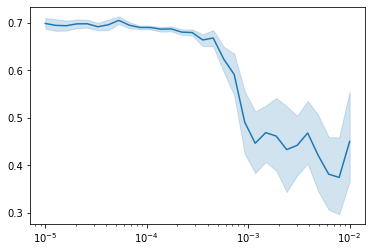

In [86]:
optimiser = Adam(model.parameters())
utils.lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-5, 1e-2], bs=8, avg_over_batches=30)

In [125]:
optimiser = Adam(model.parameters(), lr=5e-4)
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.6840, val_loss = 0.6372, val_accuracy : 0.700, time = 7s
Epoch : 1, batch : 200, train_loss = 0.6161, val_loss = 0.5060, val_accuracy : 0.777, time = 18s
Epoch : 1, batch : 300, train_loss = 0.5398, val_loss = 0.4545, val_accuracy : 0.810, time = 28s
Epoch : 2, batch : 100, train_loss = 0.4660, val_loss = 0.4117, val_accuracy : 0.817, time = 38s
Epoch : 2, batch : 200, train_loss = 0.3930, val_loss = 0.3888, val_accuracy : 0.847, time = 47s
Epoch : 2, batch : 300, train_loss = 0.4327, val_loss = 0.3807, val_accuracy : 0.833, time = 55s
Epoch : 3, batch : 100, train_loss = 0.3890, val_loss = 0.3809, val_accuracy : 0.853, time = 64s
Epoch : 3, batch : 200, train_loss = 0.3263, val_loss = 0.3632, val_accuracy : 0.863, time = 72s
Epoch : 3, batch : 300, train_loss = 0.3892, val_loss = 0.3543, val_accuracy : 0.843, time = 80s
Epoch : 4, batch : 100, train_loss = 0.3558, val_loss = 0.3462, val_accuracy : 0.860, time = 89s
Epoch : 4, batch : 200, train_l

In [126]:
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, epochs=3, bs=8)

Epoch : 1, batch : 100, train_loss = 0.2839, val_loss = 0.3240, val_accuracy : 0.873, time = 7s
Epoch : 1, batch : 200, train_loss = 0.2374, val_loss = 0.3342, val_accuracy : 0.877, time = 16s
Epoch : 1, batch : 300, train_loss = 0.3081, val_loss = 0.3387, val_accuracy : 0.853, time = 25s
Epoch : 2, batch : 100, train_loss = 0.2892, val_loss = 0.3278, val_accuracy : 0.877, time = 34s
Epoch : 2, batch : 200, train_loss = 0.2381, val_loss = 0.3316, val_accuracy : 0.873, time = 43s
Epoch : 2, batch : 300, train_loss = 0.2976, val_loss = 0.3419, val_accuracy : 0.857, time = 52s
Epoch : 3, batch : 100, train_loss = 0.2893, val_loss = 0.3244, val_accuracy : 0.870, time = 62s
Epoch : 3, batch : 200, train_loss = 0.2444, val_loss = 0.3298, val_accuracy : 0.877, time = 73s
Epoch : 3, batch : 300, train_loss = 0.3006, val_loss = 0.3324, val_accuracy : 0.863, time = 83s


In [128]:
model.embedding.weight.requires_grad_(True);
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.2793, val_loss = 0.3192, val_accuracy : 0.867, time = 10s
Epoch : 1, batch : 200, train_loss = 0.2440, val_loss = 0.3160, val_accuracy : 0.873, time = 21s
Epoch : 1, batch : 300, train_loss = 0.2778, val_loss = 0.3182, val_accuracy : 0.870, time = 34s
Epoch : 2, batch : 100, train_loss = 0.2754, val_loss = 0.3100, val_accuracy : 0.877, time = 48s
Epoch : 2, batch : 200, train_loss = 0.2172, val_loss = 0.3091, val_accuracy : 0.873, time = 60s
Epoch : 2, batch : 300, train_loss = 0.2628, val_loss = 0.3175, val_accuracy : 0.877, time = 72s
Epoch : 3, batch : 100, train_loss = 0.2474, val_loss = 0.3009, val_accuracy : 0.880, time = 83s
Epoch : 3, batch : 200, train_loss = 0.1998, val_loss = 0.3062, val_accuracy : 0.887, time = 96s
Epoch : 3, batch : 300, train_loss = 0.2676, val_loss = 0.3061, val_accuracy : 0.887, time = 107s
Epoch : 4, batch : 100, train_loss = 0.2304, val_loss = 0.2945, val_accuracy : 0.887, time = 119s
Epoch : 4, batch : 200, trai

In [129]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*utils.validate(ds_test, loss_fn, model)))

Test loss : 0.27964, test accuracy : 0.897


<br>

#### what's the average loss vs. review length?

In [141]:
torch.cumsum(torch.tensor([3,3,10]), dim=0) - torch.tensor(3)

tensor([ 0,  3, 13])

In [131]:
def test(ds, loss_fn, model, bs=1, device=device):
    model.eval()
    with torch.no_grad():
        size = len(ds)
        losses = []
        lengths = []
        for i, batch in enumerate(BucketIterator(ds, bs, sort_key=lambda x: len(x.review), shuffle=False, device=device)):
            output = model(batch.review)
            losses.extend([loss_fn(out.unsqueeze(0), label.unsqueeze(0)).item() for out, label in zip(output, batch.label)])
            lengths.extend(batch.review[1].tolist())
    model.train()
        
    return losses, lengths

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
losses, lengths = test(ds_train, nn.CrossEntropyLoss().to(device), model, bs=16)

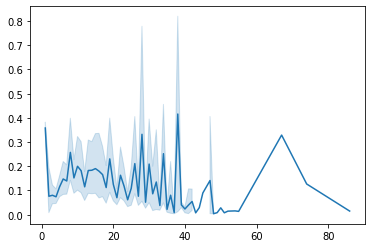

In [133]:
sns.lineplot(lengths, losses)
plt.show()

(array([106., 100.,  54.,  24.,   8.,   5.,   2.,   0.,   0.,   1.]),
 array([ 3. ,  9.8, 16.6, 23.4, 30.2, 37. , 43.8, 50.6, 57.4, 64.2, 71. ]),
 <a list of 10 Patch objects>)

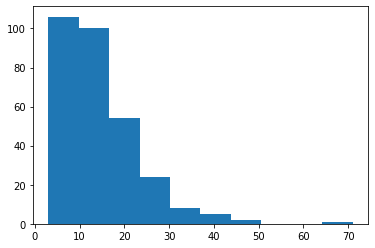

In [112]:
plt.hist(lengths)

<br>

<br>

<br>

<br>

In [ ]:
# if not os.path.exists('models'):
#     os.makedirs('models')
# torch.save(model.state_dict(), 'models/model_GRU_*.pt')